Setting up Void RSD model #5 .
Reading covariance matrix: /Volumes/BlackIce/eboss/minerva_cats/void_stats/real_redshift/Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids_Model5_CovMat.npy


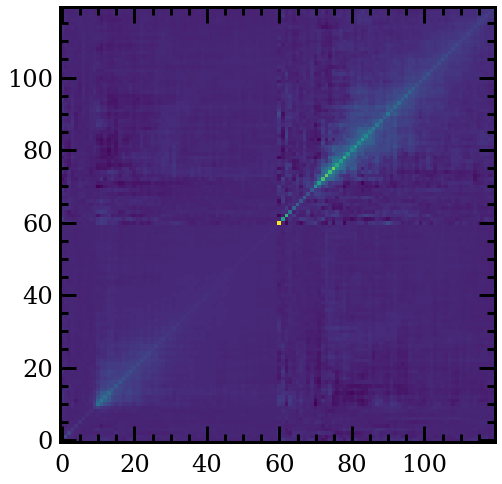

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from python_tools.model5 import Model5
from python_tools.cosmology import Cosmology
import emcee
import corner
%matplotlib inline

root_real='/Volumes/BlackIce/eboss/minerva_cats/void_stats/real_real/'
root_redshift='/Volumes/BlackIce/eboss/minerva_cats/void_stats/real_redshift/'

xi_smu_obs= root_redshift + "Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu"
xi_smu_mocks= root_redshift + "Galaxies_HOD_*_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu"
xi_r= root_real + "Galaxies_HOD_z0.57_Real_Real.SVF_recen_ovl0.5_MedianVoids.VG_CCF_monopole"
delta_r= root_real + "Galaxies_HOD_z0.57_Real_Real.SVF_recen_ovl0.5_MedianVoids.VM_CCF_monopole"
sv_r= root_real + "Galaxies_HOD_z0.57_Real_Real.SVF_recen_ovl0.5_MedianVoids.VG_CCF_losvel"
covmat= root_redshift + "Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids_Model5_CovMat.npy"

model = Model5(delta_r_file=delta_r, xi_r_file=xi_r, sv_file=sv_r, xi_smu_file=xi_smu_obs,
                 covmat_file=covmat, xi_smu_mocks=xi_smu_mocks)


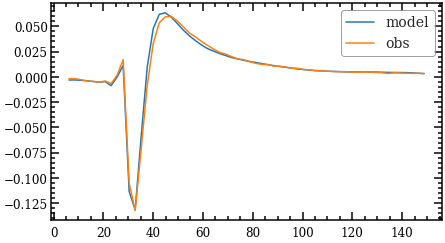

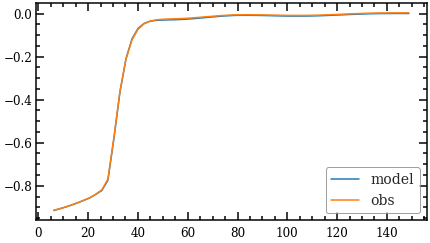

true_fs8: 0.47272825720543027
true_bs8: 1.2756524915543526
true_f: 0.7596841096514576
true_beta: 0.37057761446412574
0.01164427162767223


In [2]:
%matplotlib inline
plt.style.use('enrique')

s = model.s_for_xi
mu = model.mu_for_xi
true_sigma_v = 300
alpha = 1.0
true_epsilon = 1.0
true_alpha_para = alpha * true_epsilon ** (-2/3)
true_alpha_perp = true_epsilon * true_alpha_para
true_fs8 = model.f * model.s8norm
true_bs8 = model.b * model.s8norm

xi0_model, xibar_model, xi2_model = model.theory_multipoles(true_fs8, true_bs8, true_sigma_v,
                                                            true_alpha_perp, true_alpha_para, s, mu)

xi0_obs = model.xi0_s
xi2_obs = model.xi2_s

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(s, xi2_model, ls='-', label='model')
ax.plot(s, xi2_obs, ls='-', label='obs')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(s, xi0_model, ls='-', label='model')
ax.plot(s, xi0_obs, ls='-', label='obs')
ax.legend()
plt.show()

print('true_fs8: {}'.format(true_fs8))
print('true_bs8: {}'.format(true_bs8))
print('true_f: {}'.format(model.f))
print('true_beta: {}'.format(true_fs8/true_bs8))

print(model.iaH)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from python_tools.cosmology import Cosmology
import emcee
import corner

chain = '/Volumes/BlackIce/eboss/minerva_cats/\
void_stats/real_redshift/\
Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu_Model5_emceeChain.h5'

# true values from Minerva cosmology
#true_fs8 = CaiModel.fs8
#true_bs8 = CaiModel.bs8
#true_beta = true_fs8 / true_bs8
#true_epsilon = 1

# best fit values from emcee
reader = emcee.backends.HDFBackend(chain)
#flat_samples = reader.get_chain(discard=50, thin=15, flat=True)
flat_samples = reader.get_chain(flat=True)
best_fs8 = np.percentile(flat_samples[:, 0], 50)
best_bs8 = np.percentile(flat_samples[:, 1], 50)

print('best_fs8: ' + str(best_fs8))
#print('true_bs8: ' + str(true_beta))

#print('best_epsilon: ' + str(best_epsilon))
#print('true_epsilon: ' + str(true_epsilon))

best_fs8: 0.49533281698745896


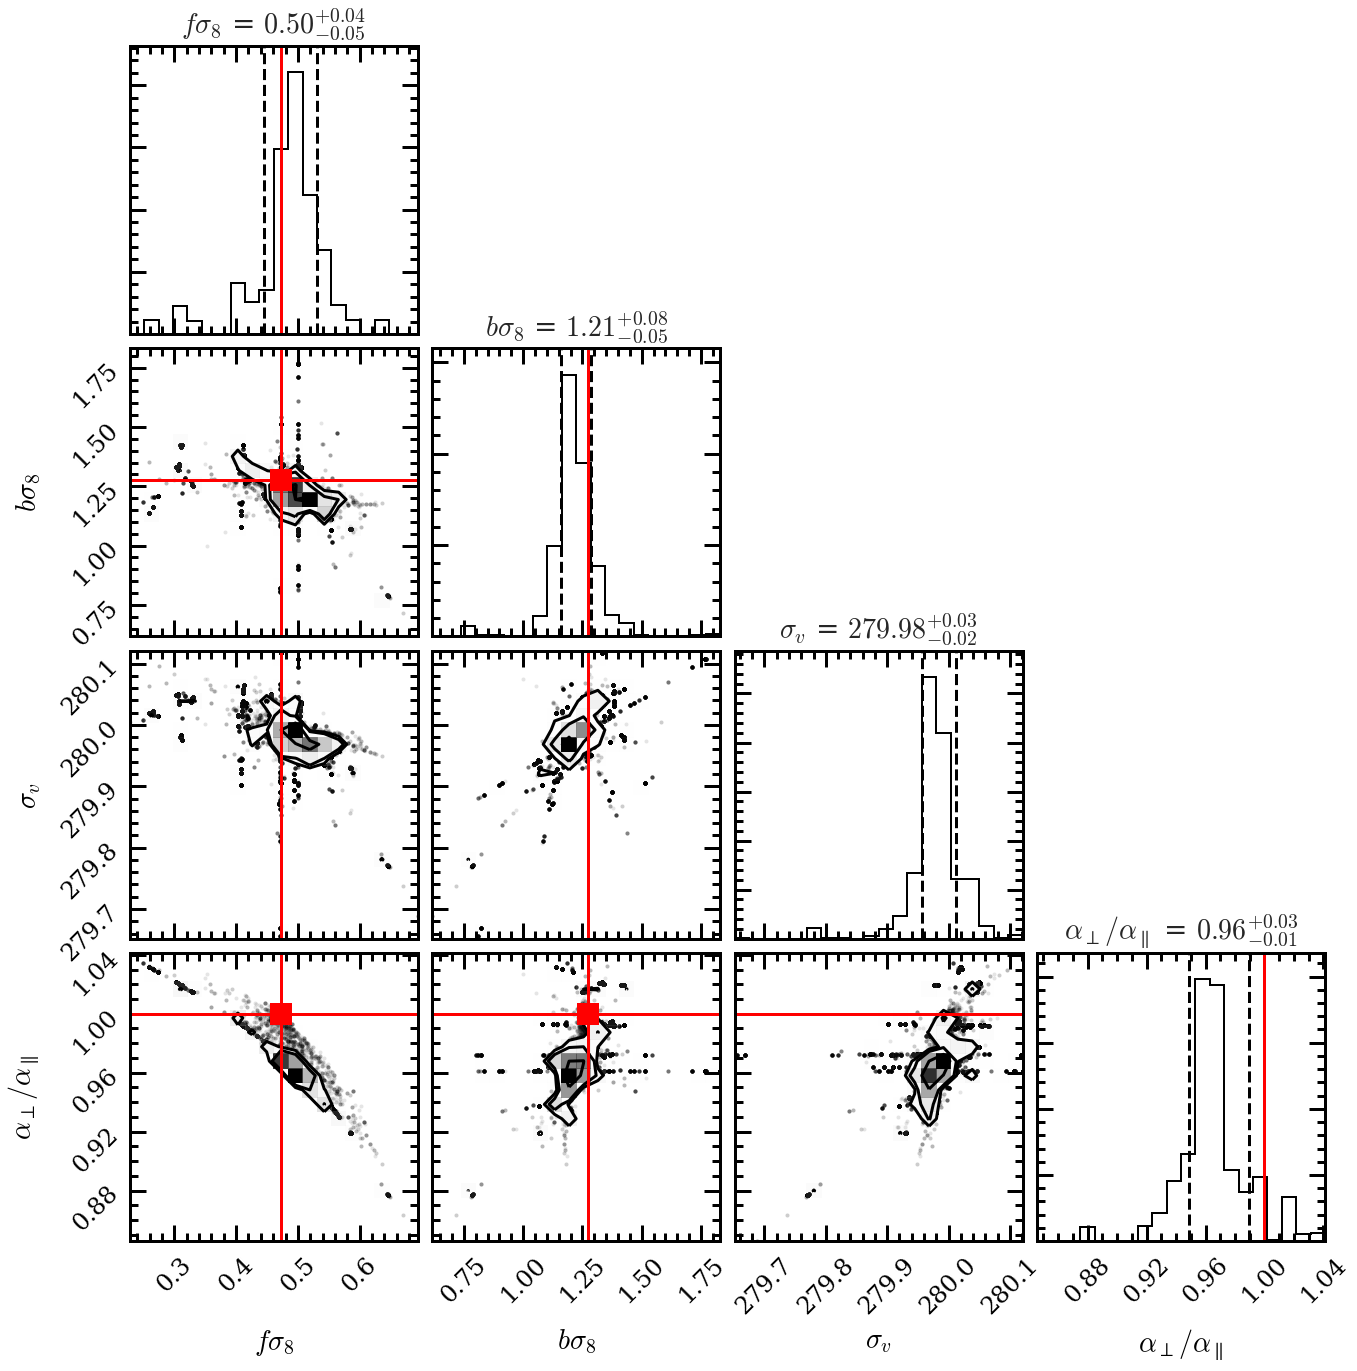

In [5]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Corner
flat_samples = reader.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=[r"$f \sigma_8$", r"$b \sigma_8$", r"$\sigma_v$",
                    r"$\alpha_{\perp} / \alpha_{\parallel}$"],
                    show_titles=True, quantiles=[0.16, 0.84], truths=[true_fs8, true_bs8,
                                                                     true_sigma_v, true_epsilon],
                   truth_color='r')
#fout = '/Volumes/BlackIce/eboss/' + CaiModel.handle_obs.split('/')[-1] + '_emceeCorner.png'
#print('Saving corner: ' + fout)
#plt.savefig(fout)
plt.show()

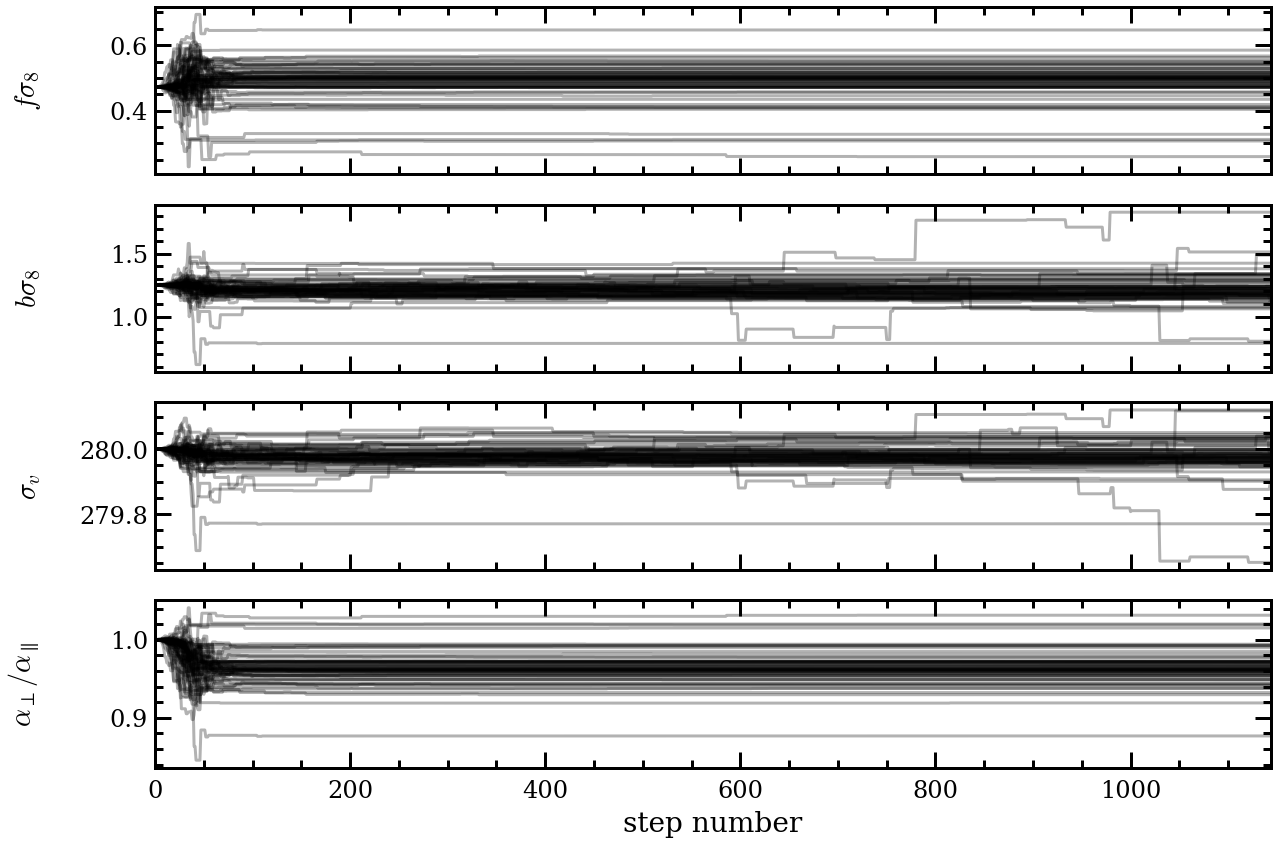

In [6]:
ndim=4
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = reader.get_chain()
labels=[r"$f \sigma_8$", r"$b \sigma_8$", r"$\sigma_v$",
        r"$\alpha_{\perp} / \alpha_{\parallel}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from python_tools.model2 import Model2
from python_tools.cosmology import Cosmology
import emcee
import corner
%matplotlib inline

root_real='/Volumes/BlackIce/eboss/minerva_cats/void_stats/real_real/'
root_redshift='/Volumes/BlackIce/eboss/minerva_cats/void_stats/real_redshift/'

xi_smu_obs= root_redshift + "Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu"
xi_smu_mocks= root_redshift + "Galaxies_HOD_*_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids.VG_CCF_rmu"
xi_r= root_real + "Galaxies_HOD_z0.57_Real_Real.SVF_recen_ovl0.5_MedianVoids.VG_CCF_monopole"
delta_r= root_real + "Galaxies_HOD_z0.57_Real_Real.SVF_recen_ovl0.5_MedianVoids.VM_CCF_monopole"
sv_r= root_real + "Galaxies_HOD_z0.57_Real_Real.SVF_recen_ovl0.5_MedianVoids.VG_CCF_losvel"
covmat= root_redshift + "Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids_Model5_CovMat.npy"

model2 = Model2(delta_r_file=delta_r, xi_r_file=xi_r, xi_smu_file=xi_smu_obs,
                 covmat_file=covmat, xi_smu_mocks=xi_smu_mocks)

Setting up Void RSD model #2 .
Reading covariance matrix: /Volumes/BlackIce/eboss/minerva_cats/void_stats/real_redshift/Galaxies_HOD_z0.57_Real_Redshift.SVF_recen_ovl0.5_MedianVoids_Model5_CovMat.npy


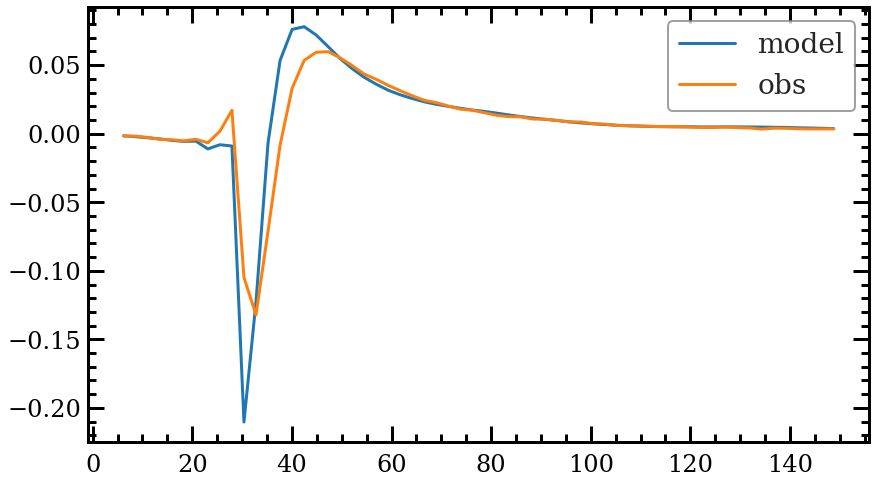

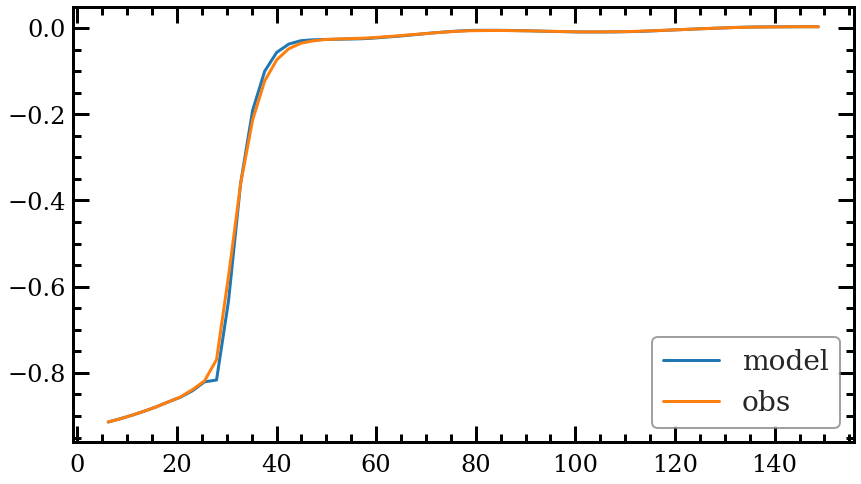

true_fs8: 0.47272825720543027
true_bs8: 1.250761711231341
true_f: 0.7596841096514576
true_beta: 0.37795229335893415


In [12]:
%matplotlib inline
plt.style.use('enrique')

s = model2.s_for_xi
mu = model2.mu_for_xi
alpha = 1.0
true_epsilon = 1.0
true_alpha_para = alpha * true_epsilon ** (-2/3)
true_alpha_perp = true_epsilon * true_alpha_para
true_fs8 = model2.f * model2.s8norm
true_bs8 = model2.b * model2.s8norm

xi0_model, xibar_model, xi2_model = model2.theory_multipoles(true_fs8, true_bs8,
                                                            true_alpha_perp, true_alpha_para, s, mu)

xi0_obs = model2.xi0_s
xi2_obs = model2.xi2_s

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(s, xi2_model, ls='-', label='model')
ax.plot(s, xi2_obs, ls='-', label='obs')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(s, xi0_model, ls='-', label='model')
ax.plot(s, xi0_obs, ls='-', label='obs')
ax.legend()
plt.show()

print('true_fs8: {}'.format(true_fs8))
print('true_bs8: {}'.format(true_bs8))
print('true_f: {}'.format(model2.f))
print('true_beta: {}'.format(true_fs8/true_bs8))